## Skin cancer lesion classification using the HAM10000 dataset

### Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

### Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

### The 7 classes of skin cancer lesions included in this dataset are:
    Melanocytic nevi (nv) 

    Melanoma (mel) 

    Benign keratosis-like lesions (bkl) 

    Basal cell carcinoma (bcc)  

    Actinic keratoses (akiec) 

    Vascular lesions (vas) 

    Dermatofibroma (df) 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [5]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [6]:
pip install keras-utils

Note: you may need to restart the kernel to use updated packages.


In [7]:
import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [8]:
skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

In [10]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [11]:
SIZE=32

In [12]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])

LabelEncoder()

In [13]:
LabelEncoder()

LabelEncoder()

In [14]:
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [15]:
skin_df['label'] = le.transform(skin_df["dx"]) 

In [16]:
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\User\AppData\Local\Temp\ipykernel_9996\3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


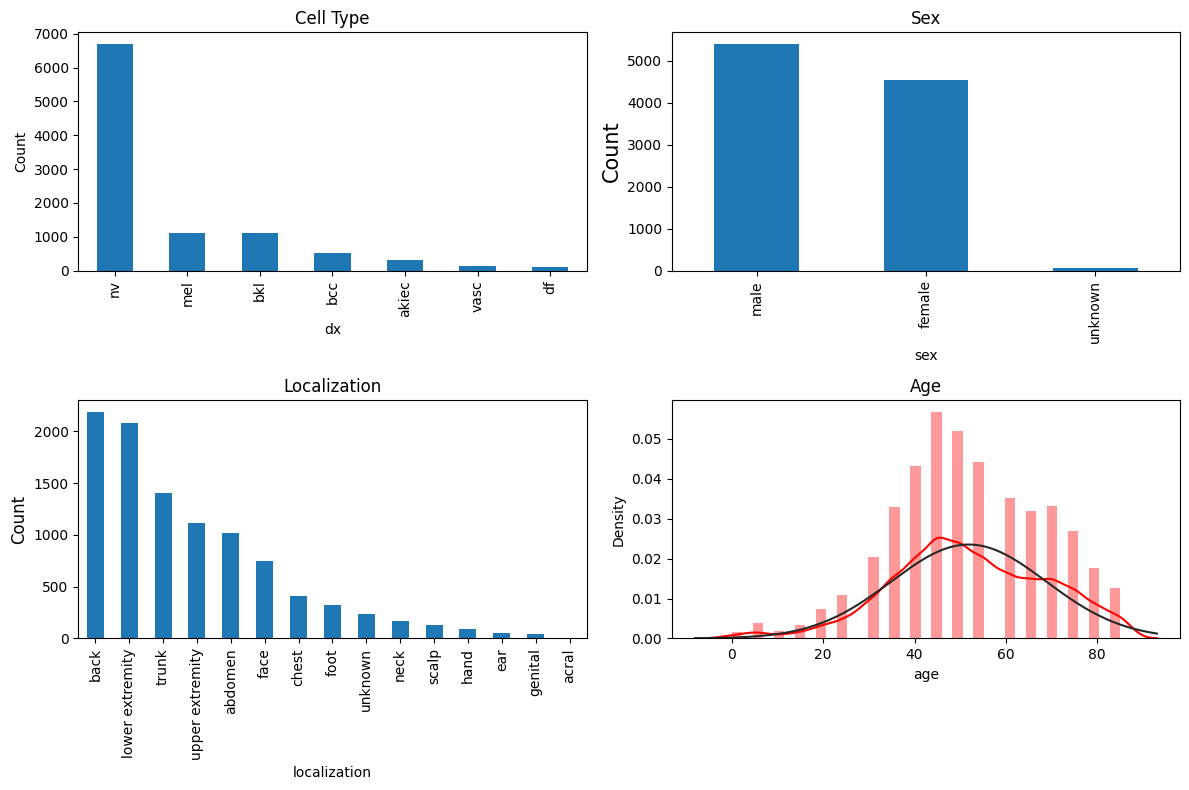

In [17]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.utils import resample

In [20]:
# Distribution of data into various classes 
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


### Balance data.
#### We are assigning weights during model.fit
#### Separate each classes, resample, and combine back into single dataframe

In [21]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [25]:
df_0

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9687,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,0
9688,HAM_0006002,ISIC_0029915,akiec,histo,50.0,female,face,0
9689,HAM_0000549,ISIC_0029360,akiec,histo,70.0,male,upper extremity,0
9690,HAM_0000549,ISIC_0026152,akiec,histo,70.0,male,upper extremity,0
9691,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,0
...,...,...,...,...,...,...,...,...
10009,HAM_0005705,ISIC_0031430,akiec,histo,75.0,female,lower extremity,0
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0


In [26]:
df_1

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2462,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,1
2463,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,1
2464,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,1
2465,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,1
2466,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,1
...,...,...,...,...,...,...,...,...
2971,HAM_0001573,ISIC_0028542,bcc,histo,45.0,male,chest,1
2972,HAM_0001215,ISIC_0025260,bcc,histo,70.0,male,back,1
2973,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back,1
2974,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,1


In [27]:
df_2

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
3326,HAM_0002276,ISIC_0025366,bkl,consensus,50.0,female,trunk,2
7100,HAM_0006159,ISIC_0028977,bkl,consensus,50.0,female,upper extremity,2
9546,HAM_0003807,ISIC_0032655,bkl,consensus,40.0,male,unknown,2
9630,HAM_0003807,ISIC_0033620,bkl,consensus,40.0,male,unknown,2


In [28]:
df_3

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,3
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,3
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,3
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,3
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,3
...,...,...,...,...,...,...,...,...
1205,HAM_0007569,ISIC_0025373,df,consensus,35.0,female,lower extremity,3
1206,HAM_0001841,ISIC_0025771,df,consensus,35.0,female,lower extremity,3
1207,HAM_0006707,ISIC_0030870,df,consensus,45.0,female,lower extremity,3
1208,HAM_0002153,ISIC_0029297,df,consensus,40.0,female,lower extremity,3


In [29]:
df_4

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,4
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,4
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,4
1214,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,4
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,4
...,...,...,...,...,...,...,...,...
2319,HAM_0001953,ISIC_0025611,mel,histo,65.0,male,back,4
6769,HAM_0002552,ISIC_0032985,mel,histo,25.0,male,upper extremity,4
8820,HAM_0002552,ISIC_0032936,mel,histo,25.0,male,upper extremity,4
8834,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity,4


In [30]:
df_5

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face,5
1210,HAM_0000559,ISIC_0024693,nv,follow_up,45.0,female,upper extremity,5
2976,HAM_0004932,ISIC_0032212,nv,follow_up,45.0,female,foot,5
2977,HAM_0004516,ISIC_0025775,nv,follow_up,45.0,female,neck,5
2978,HAM_0006510,ISIC_0029828,nv,follow_up,55.0,female,lower extremity,5
...,...,...,...,...,...,...,...,...
9682,HAM_0006283,ISIC_0027924,nv,consensus,20.0,male,chest,5
9683,HAM_0000102,ISIC_0031547,nv,consensus,20.0,male,back,5
9684,HAM_0000102,ISIC_0032221,nv,consensus,20.0,male,back,5
9685,HAM_0005314,ISIC_0030693,nv,consensus,40.0,male,neck,5


In [31]:
df_6

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2320,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,6
2321,HAM_0006889,ISIC_0031270,vasc,histo,20.0,male,upper extremity,6
2322,HAM_0001920,ISIC_0029486,vasc,histo,55.0,male,back,6
2323,HAM_0001920,ISIC_0031901,vasc,histo,55.0,male,back,6
2324,HAM_0005155,ISIC_0032076,vasc,histo,85.0,male,lower extremity,6
...,...,...,...,...,...,...,...,...
2457,HAM_0000415,ISIC_0025680,vasc,consensus,55.0,female,trunk,6
2458,HAM_0004413,ISIC_0026068,vasc,consensus,55.0,female,abdomen,6
2459,HAM_0004257,ISIC_0025452,vasc,consensus,55.0,female,abdomen,6
2460,HAM_0003829,ISIC_0026349,vasc,consensus,60.0,female,trunk,6


In [32]:
n_samples=500 

In [34]:
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [35]:
df_0_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
9837,HAM_0003262,ISIC_0026212,akiec,histo,45.0,male,face,0
9876,HAM_0003401,ISIC_0029598,akiec,histo,55.0,male,face,0
9910,HAM_0005024,ISIC_0025803,akiec,histo,80.0,male,face,0
9723,HAM_0005310,ISIC_0027231,akiec,histo,85.0,male,back,0


In [36]:
df_1_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2564,HAM_0001907,ISIC_0025513,bcc,histo,40.0,male,back,1
2897,HAM_0006904,ISIC_0027281,bcc,histo,70.0,male,back,1
2732,HAM_0004027,ISIC_0024595,bcc,histo,65.0,female,back,1
2568,HAM_0006384,ISIC_0031272,bcc,histo,80.0,male,face,1
2533,HAM_0005921,ISIC_0030800,bcc,histo,75.0,male,lower extremity,1
...,...,...,...,...,...,...,...,...
2469,HAM_0006834,ISIC_0029193,bcc,histo,85.0,male,face,1
2583,HAM_0006572,ISIC_0030349,bcc,histo,75.0,male,back,1
2809,HAM_0002083,ISIC_0024432,bcc,histo,65.0,male,face,1
2551,HAM_0001326,ISIC_0031824,bcc,histo,60.0,male,scalp,1


In [37]:
df_2_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
861,HAM_0005580,ISIC_0029235,bkl,consensus,80.0,male,face,2
7100,HAM_0006159,ISIC_0028977,bkl,consensus,50.0,female,upper extremity,2
1045,HAM_0005751,ISIC_0028386,bkl,consensus,50.0,female,upper extremity,2
122,HAM_0000344,ISIC_0032972,bkl,histo,55.0,male,trunk,2
467,HAM_0005935,ISIC_0026679,bkl,histo,70.0,female,chest,2
...,...,...,...,...,...,...,...,...
46,HAM_0002299,ISIC_0025819,bkl,histo,75.0,female,face,2
656,HAM_0003938,ISIC_0030231,bkl,histo,55.0,female,upper extremity,2
471,HAM_0000744,ISIC_0029474,bkl,histo,70.0,male,face,2
971,HAM_0000948,ISIC_0033631,bkl,consensus,NaN,unknown,unknown,2


In [38]:
df_3_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1197,HAM_0004065,ISIC_0026629,df,consensus,65.0,female,lower extremity,3
1146,HAM_0005861,ISIC_0028346,df,histo,65.0,female,lower extremity,3
1187,HAM_0006787,ISIC_0026471,df,consensus,60.0,male,lower extremity,3
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,3
1201,HAM_0000049,ISIC_0029130,df,consensus,70.0,male,lower extremity,3
...,...,...,...,...,...,...,...,...
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,3
1186,HAM_0006816,ISIC_0026254,df,consensus,45.0,male,lower extremity,3
1192,HAM_0004496,ISIC_0028651,df,consensus,55.0,female,lower extremity,3
1160,HAM_0002450,ISIC_0024396,df,consensus,65.0,female,lower extremity,3


In [39]:
df_4_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2071,HAM_0002523,ISIC_0024516,mel,histo,40.0,male,back,4
2306,HAM_0001910,ISIC_0028968,mel,histo,55.0,male,upper extremity,4
2255,HAM_0001953,ISIC_0031498,mel,histo,65.0,male,back,4
1332,HAM_0005588,ISIC_0026458,mel,histo,80.0,female,lower extremity,4
1677,HAM_0007086,ISIC_0033863,mel,histo,65.0,female,back,4
...,...,...,...,...,...,...,...,...
2025,HAM_0006497,ISIC_0027302,mel,histo,35.0,female,lower extremity,4
1290,HAM_0002714,ISIC_0026113,mel,histo,50.0,male,abdomen,4
2096,HAM_0002609,ISIC_0032070,mel,histo,60.0,female,back,4
1413,HAM_0002981,ISIC_0028087,mel,histo,65.0,female,back,4


In [40]:
df_5_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
3835,HAM_0000474,ISIC_0030099,nv,follow_up,45.0,female,hand,5
8367,HAM_0000597,ISIC_0030654,nv,histo,35.0,female,abdomen,5
8203,HAM_0007585,ISIC_0032347,nv,histo,35.0,female,back,5
8168,HAM_0005902,ISIC_0027285,nv,histo,40.0,female,foot,5
6747,HAM_0004380,ISIC_0026251,nv,histo,30.0,female,face,5
...,...,...,...,...,...,...,...,...
3966,HAM_0004634,ISIC_0032454,nv,follow_up,65.0,male,trunk,5
7119,HAM_0007541,ISIC_0032691,nv,histo,30.0,male,abdomen,5
7341,HAM_0006391,ISIC_0032821,nv,histo,70.0,female,lower extremity,5
7442,HAM_0000747,ISIC_0034044,nv,histo,30.0,male,trunk,5


In [41]:
df_6_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2422,HAM_0006796,ISIC_0025707,vasc,consensus,35.0,male,trunk,6
2412,HAM_0000934,ISIC_0031706,vasc,consensus,60.0,male,trunk,6
2334,HAM_0002218,ISIC_0025578,vasc,histo,5.0,male,back,6
2426,HAM_0005215,ISIC_0028406,vasc,consensus,80.0,male,abdomen,6
2391,HAM_0001566,ISIC_0031346,vasc,consensus,70.0,female,face,6
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


### Combined back to a single dataframe

In [42]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [43]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


### Check the distribution. All classes should be balanced now.

In [44]:
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


### Now time to read images based on image ID from the CSV file
This is the safest way to read images as it ensures the right image is read for the right ID

In [45]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

In [46]:
image_path

{'ISIC_0024306': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024306.jpg',
 'ISIC_0024307': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024307.jpg',
 'ISIC_0024308': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024308.jpg',
 'ISIC_0024309': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024309.jpg',
 'ISIC_0024310': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024310.jpg',
 'ISIC_0024311': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024311.jpg',
 'ISIC_0024312': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024312.jpg',
 'ISIC_0024313': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024313.jpg',
 'ISIC_0024314': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024314.jpg',
 'ISIC_0024315': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024315.jpg',
 'ISIC_0024316': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024316.jpg',
 'ISIC_0024317': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024317.jpg',
 'ISIC_0024318': 'data/HAM10000\\HAM10000_images_part_1\\ISIC_0024318.jpg',
 'ISIC_00243

In [47]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [48]:
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [49]:
skin_df_balanced['path']

9789    data/HAM10000\HAM10000_images_part_1\ISIC_0026...
9957    data/HAM10000\HAM10000_images_part_1\ISIC_0025...
9793    data/HAM10000\HAM10000_images_part_1\ISIC_0024...
9758    data/HAM10000\HAM10000_images_part_1\ISIC_0027...
9875    data/HAM10000\HAM10000_images_part_1\ISIC_0029...
                              ...                        
2375    data/HAM10000\HAM10000_images_part_2\ISIC_0033...
2436    data/HAM10000\HAM10000_images_part_1\ISIC_0027...
2453    data/HAM10000\HAM10000_images_part_1\ISIC_0024...
2377    data/HAM10000\HAM10000_images_part_2\ISIC_0033...
2363    data/HAM10000\HAM10000_images_part_2\ISIC_0033...
Name: path, Length: 3500, dtype: object

In [50]:
skin_df_balanced['image']

9789    [[[155, 118, 107], [162, 126, 118], [174, 140,...
9957    [[[138, 76, 82], [131, 64, 68], [139, 73, 81],...
9793    [[[123, 86, 87], [174, 137, 137], [197, 161, 1...
9758    [[[205, 149, 175], [207, 149, 169], [214, 158,...
9875    [[[203, 174, 199], [205, 174, 197], [206, 175,...
                              ...                        
2375    [[[15, 12, 12], [40, 30, 32], [87, 67, 71], [1...
2436    [[[148, 109, 118], [121, 93, 102], [112, 87, 9...
2453    [[[248, 181, 199], [248, 183, 201], [248, 186,...
2377    [[[180, 133, 143], [189, 147, 158], [192, 150,...
2363    [[[192, 174, 169], [197, 179, 175], [200, 179,...
Name: image, Length: 3500, dtype: object

In [51]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data/HAM10000\HAM10000_images_part_1\ISIC_0026...,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data/HAM10000\HAM10000_images_part_1\ISIC_0025...,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data/HAM10000\HAM10000_images_part_1\ISIC_0024...,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data/HAM10000\HAM10000_images_part_1\ISIC_0027...,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data/HAM10000\HAM10000_images_part_1\ISIC_0029...,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."
...,...,...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6,data/HAM10000\HAM10000_images_part_2\ISIC_0033...,"[[[15, 12, 12], [40, 30, 32], [87, 67, 71], [1..."
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6,data/HAM10000\HAM10000_images_part_1\ISIC_0027...,"[[[148, 109, 118], [121, 93, 102], [112, 87, 9..."
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6,data/HAM10000\HAM10000_images_part_1\ISIC_0024...,"[[[248, 181, 199], [248, 183, 201], [248, 186,..."
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6,data/HAM10000\HAM10000_images_part_2\ISIC_0033...,"[[[180, 133, 143], [189, 147, 158], [192, 150,..."


In [52]:
n_samples = 5  # number of samples for plotting

## Plotting

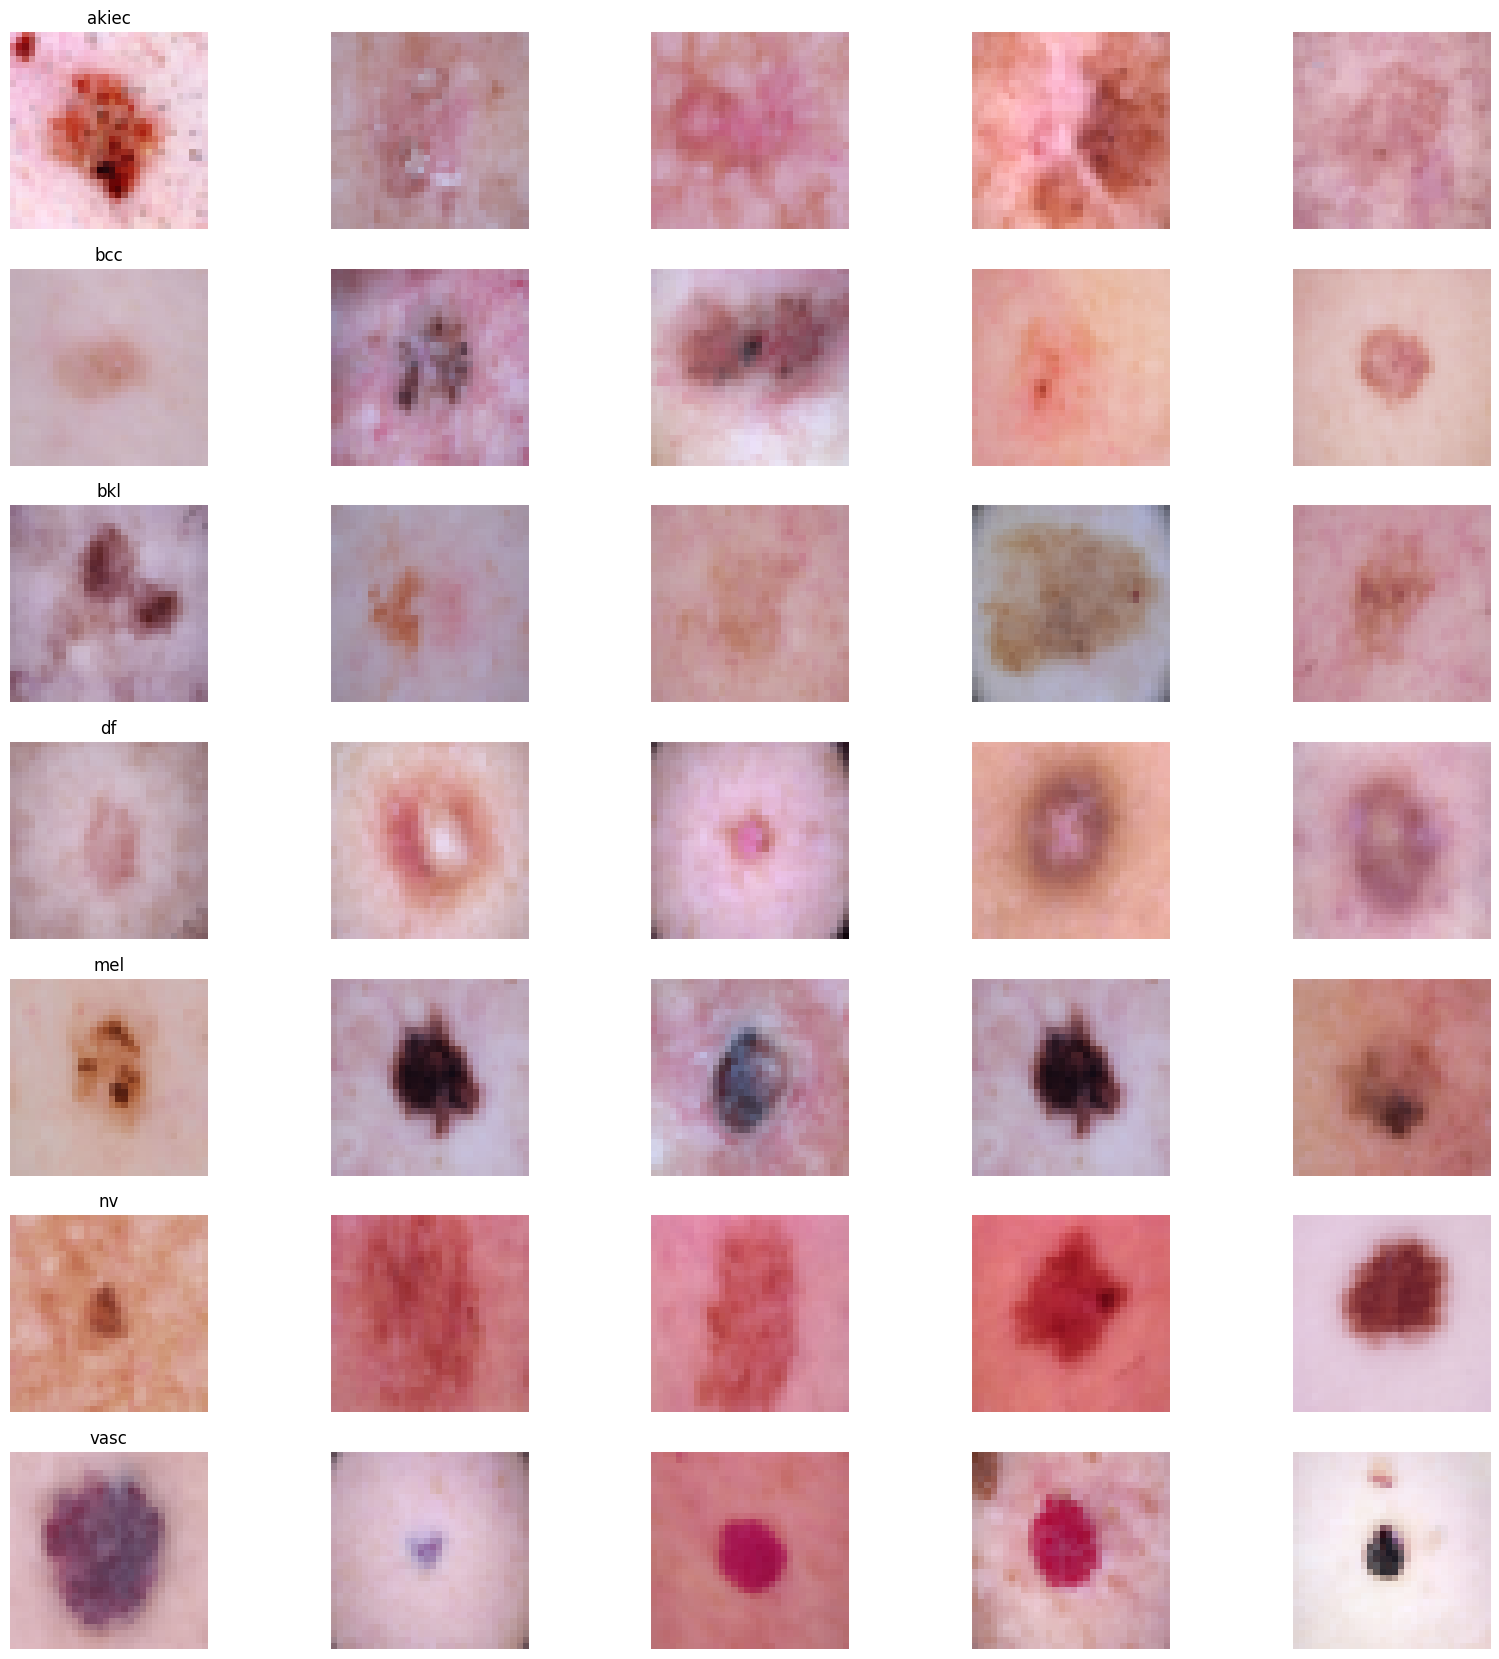

In [53]:
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [54]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.

In [55]:
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [56]:
X

array([[[[0.60784314, 0.4627451 , 0.41960784],
         [0.63529412, 0.49411765, 0.4627451 ],
         [0.68235294, 0.54901961, 0.54117647],
         ...,
         [0.62352941, 0.4627451 , 0.40392157],
         [0.63137255, 0.50196078, 0.47058824],
         [0.53333333, 0.43137255, 0.40784314]],

        [[0.57647059, 0.41960784, 0.36470588],
         [0.61176471, 0.45882353, 0.41176471],
         [0.66666667, 0.52156863, 0.50196078],
         ...,
         [0.6745098 , 0.52156863, 0.4745098 ],
         [0.69019608, 0.56078431, 0.52156863],
         [0.6745098 , 0.56862745, 0.54509804]],

        [[0.64705882, 0.51372549, 0.48235294],
         [0.61176471, 0.45098039, 0.39215686],
         [0.61176471, 0.44313725, 0.40392157],
         ...,
         [0.6745098 , 0.52156863, 0.45882353],
         [0.65490196, 0.50980392, 0.44313725],
         [0.63137255, 0.50588235, 0.48235294]],

        ...,

        [[0.56470588, 0.42352941, 0.35294118],
         [0.58823529, 0.45098039, 0.37254902]

In [57]:
Y

9789    0
9957    0
9793    0
9758    0
9875    0
       ..
2375    6
2436    6
2453    6
2377    6
2363    6
Name: label, Length: 3500, dtype: int32

In [58]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [59]:
Y_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### Define the model.
##### We've used autokeras to find out the best model for this problem.

In [60]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

## Training

In [61]:
batch_size = 16 
epochs = 50

## Fitting the Model

In [62]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
165/165 - 22s - loss: 1.9412 - acc: 0.1661 - val_loss: 1.9853 - val_acc: 0.1406 - 22s/epoch - 134ms/step
Epoch 2/50
165/165 - 19s - loss: 1.8352 - acc: 0.2179 - val_loss: 1.8087 - val_acc: 0.2286 - 19s/epoch - 117ms/step
Epoch 3/50
165/165 - 19s - loss: 1.7514 - acc: 0.2632 - val_loss: 1.7420 - val_acc: 0.2903 - 19s/epoch - 112ms/step
Epoch 4/50
165/165 - 19s - loss: 1.5972 - acc: 0.3406 - val_loss: 1.5057 - val_acc: 0.3851 - 19s/epoch - 115ms/step
Epoch 5/50
165/165 - 19s - loss: 1.4668 - acc: 0.4194 - val_loss: 1.4399 - val_acc: 0.4069 - 19s/epoch - 115ms/step
Epoch 6/50
165/165 - 19s - loss: 1.4148 - acc: 0.4354 - val_loss: 1.3940 - val_acc: 0.3874 - 19s/epoch - 114ms/step
Epoch 7/50
165/165 - 20s - loss: 1.3645 - acc: 0.4518 - val_loss: 1.4113 - val_acc: 0.4126 - 20s/epoch - 121ms/step
Epoch 8/50
165/165 - 20s - loss: 1.3256 - acc: 0.4762 - val_loss: 1.3236 - val_acc: 0.4457 - 20s/epoch - 123ms/step
Epoch 9/50
165/165 - 19s - loss: 1.3063 - acc: 0.4823 - val_loss: 1.3102

In [64]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1] * 100, '%')

28/28 [==============================] - 1s 40ms/step - loss: 0.8921 - acc: 0.6869
Test accuracy: 68.68571639060974 %


## Plot the training and validation accuracy and loss at each epoch

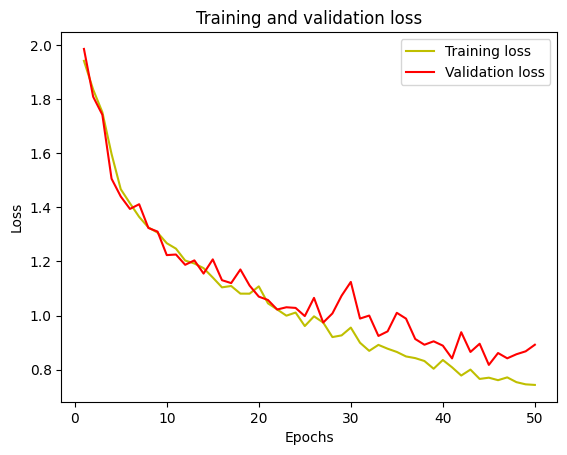

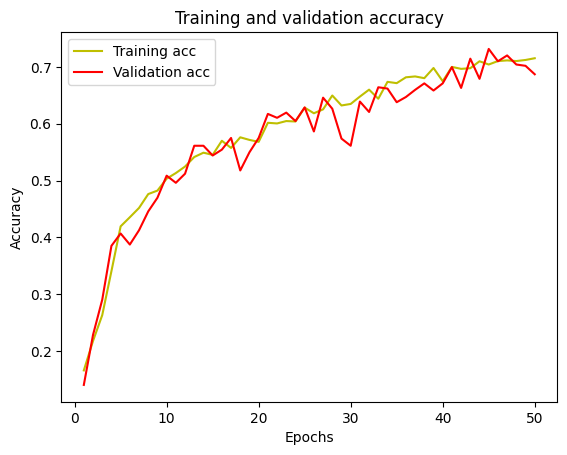

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [66]:
# Prediction on test data
y_pred = model.predict(x_test)

28/28 [==============================] - 1s 41ms/step


In [67]:
y_pred

array([[3.0550516e-01, 1.3157958e-01, 5.9379384e-02, ..., 7.6438477e-03,
        5.4817456e-03, 8.5440930e-04],
       [7.4553010e-03, 5.3323156e-01, 3.8637868e-01, ..., 4.4957705e-02,
        2.7029213e-02, 6.7826995e-04],
       [8.0777049e-02, 4.8473366e-03, 5.6901403e-02, ..., 8.4538895e-01,
        1.2019995e-02, 2.7324811e-07],
       ...,
       [3.0839012e-05, 1.4888537e-04, 4.0785220e-01, ..., 3.7784573e-01,
        2.1412043e-01, 8.7282617e-09],
       [2.9292639e-14, 1.9684448e-06, 5.7416845e-12, ..., 8.2042619e-12,
        1.5539221e-08, 9.9999797e-01],
       [1.2967979e-02, 6.9668040e-02, 7.8893107e-01, ..., 6.3888013e-02,
        5.8491342e-02, 6.8706507e-04]], dtype=float32)

In [68]:
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

In [69]:
y_pred_classes

array([3, 1, 4, 3, 2, 4, 3, 3, 2, 0, 1, 2, 6, 2, 2, 2, 2, 3, 6, 5, 0, 3,
       2, 2, 2, 2, 1, 2, 2, 6, 6, 3, 4, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 2,
       2, 0, 3, 3, 1, 2, 0, 2, 5, 6, 3, 0, 4, 0, 2, 3, 6, 5, 2, 0, 3, 6,
       2, 3, 2, 5, 5, 2, 2, 4, 1, 0, 6, 1, 6, 3, 6, 6, 6, 6, 5, 5, 2, 5,
       0, 1, 4, 6, 2, 5, 6, 4, 0, 2, 3, 1, 0, 4, 2, 2, 2, 0, 6, 6, 1, 2,
       0, 3, 2, 1, 0, 6, 6, 2, 5, 1, 1, 4, 6, 2, 1, 1, 4, 3, 1, 0, 3, 0,
       2, 6, 5, 4, 6, 6, 1, 3, 2, 6, 2, 3, 5, 5, 2, 3, 2, 0, 0, 4, 4, 1,
       5, 2, 1, 3, 2, 3, 2, 4, 2, 5, 2, 1, 1, 4, 4, 1, 3, 2, 2, 2, 3, 6,
       2, 6, 1, 6, 6, 2, 2, 0, 2, 2, 2, 3, 3, 5, 2, 5, 6, 2, 4, 6, 4, 3,
       2, 3, 2, 0, 3, 2, 2, 5, 5, 6, 6, 4, 2, 4, 6, 6, 6, 6, 2, 5, 4, 2,
       2, 2, 0, 1, 4, 3, 6, 2, 2, 3, 4, 3, 1, 6, 3, 3, 4, 3, 0, 1, 1, 0,
       0, 4, 3, 3, 3, 1, 6, 3, 2, 6, 1, 1, 1, 3, 5, 2, 1, 3, 2, 0, 0, 2,
       6, 4, 1, 5, 0, 1, 6, 3, 2, 0, 1, 0, 0, 6, 5, 3, 2, 3, 0, 6, 2, 1,
       0, 4, 1, 6, 1, 1, 3, 2, 2, 4, 5, 0, 1, 3, 1,

In [70]:
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [71]:
y_true

array([3, 4, 4, 3, 0, 4, 3, 3, 2, 0, 3, 5, 6, 1, 1, 1, 1, 2, 6, 5, 0, 3,
       0, 3, 2, 2, 1, 0, 3, 6, 6, 3, 4, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 4,
       4, 0, 3, 3, 1, 0, 0, 0, 5, 6, 2, 0, 2, 0, 4, 3, 6, 2, 1, 0, 3, 6,
       0, 3, 1, 5, 5, 1, 0, 2, 1, 4, 6, 5, 6, 3, 6, 6, 6, 6, 5, 5, 2, 5,
       0, 0, 4, 6, 1, 5, 6, 5, 0, 2, 3, 1, 0, 4, 2, 2, 0, 0, 6, 6, 1, 0,
       0, 1, 2, 1, 4, 1, 6, 1, 5, 3, 1, 5, 6, 2, 1, 1, 4, 3, 1, 0, 3, 0,
       0, 6, 4, 4, 6, 6, 1, 0, 2, 6, 4, 3, 5, 5, 4, 1, 2, 0, 0, 4, 4, 1,
       5, 2, 0, 3, 0, 3, 5, 5, 0, 5, 2, 1, 2, 4, 4, 3, 3, 1, 0, 2, 3, 6,
       1, 5, 1, 6, 6, 2, 0, 0, 2, 1, 2, 3, 3, 5, 4, 5, 6, 2, 4, 6, 4, 3,
       2, 2, 2, 0, 3, 2, 0, 5, 5, 6, 6, 4, 4, 0, 6, 6, 6, 6, 2, 5, 5, 5,
       2, 1, 0, 1, 5, 3, 6, 2, 3, 3, 4, 3, 1, 6, 1, 3, 2, 3, 0, 1, 1, 0,
       1, 5, 3, 3, 4, 1, 6, 3, 2, 6, 3, 0, 1, 3, 5, 2, 1, 3, 2, 0, 0, 5,
       6, 4, 1, 4, 0, 0, 6, 1, 0, 1, 0, 0, 0, 6, 5, 3, 2, 3, 0, 6, 0, 1,
       0, 4, 1, 6, 5, 1, 0, 0, 4, 5, 5, 1, 0, 3, 0,

In [72]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [74]:
print(cm)

[[ 84  11  43   7   4   0   0]
 [  9  77  31   7   0   1   3]
 [  2   2  89   4  15   7   1]
 [  1   8  11 108   0   0   0]
 [  3   3  36   1  52  14   3]
 [  1   6  20   0  18  67   1]
 [  0   0   0   1   0   0 124]]


<Axes: >

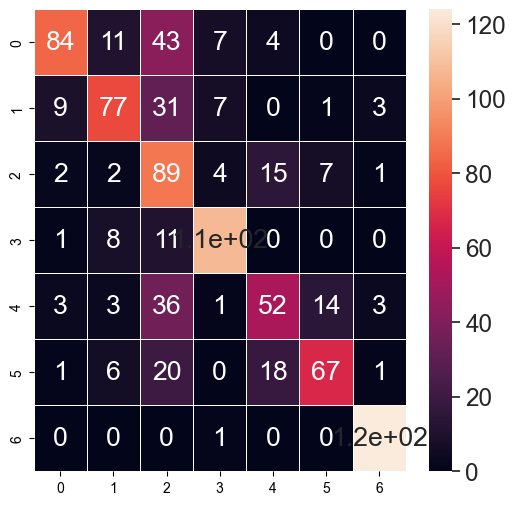

In [75]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

## PLot fractional incorrect misclassifications

Text(0, 0.5, 'Fraction of incorrect predictions')

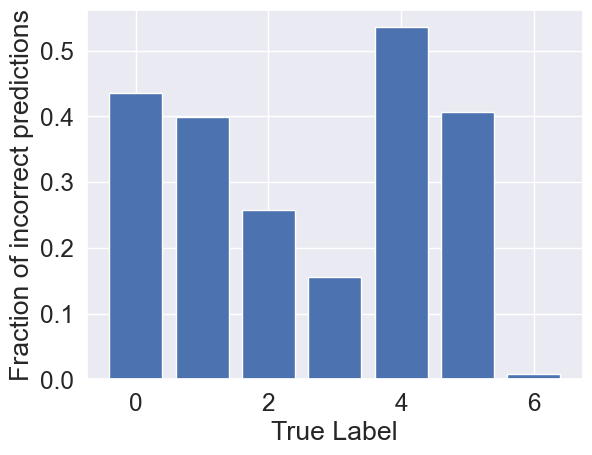

In [77]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

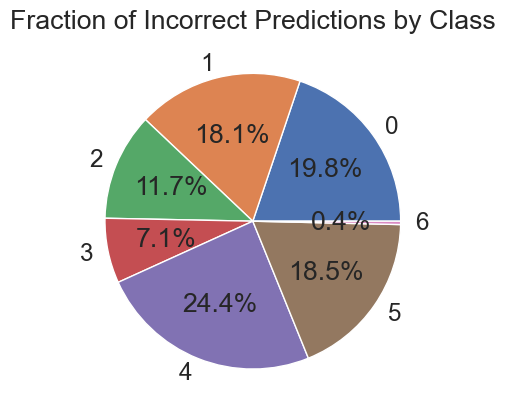

In [78]:
classes = np.arange(7)
plt.pie(incorr_fraction, labels=classes, autopct='%1.1f%%')
plt.title('Fraction of Incorrect Predictions by Class')
plt.show()

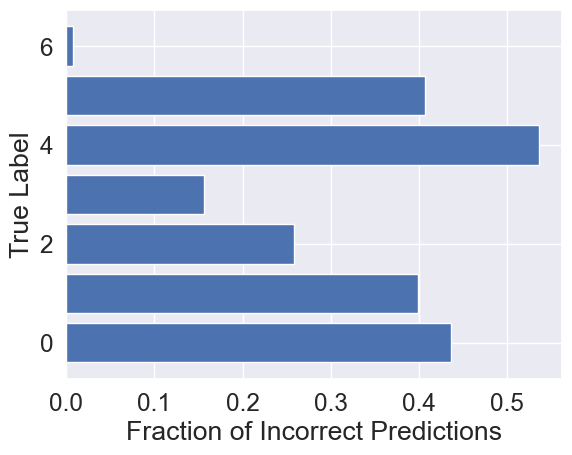

In [81]:
plt.barh(classes, incorr_fraction)
plt.xlabel('Fraction of Incorrect Predictions')
plt.ylabel('True Label')
plt.show()

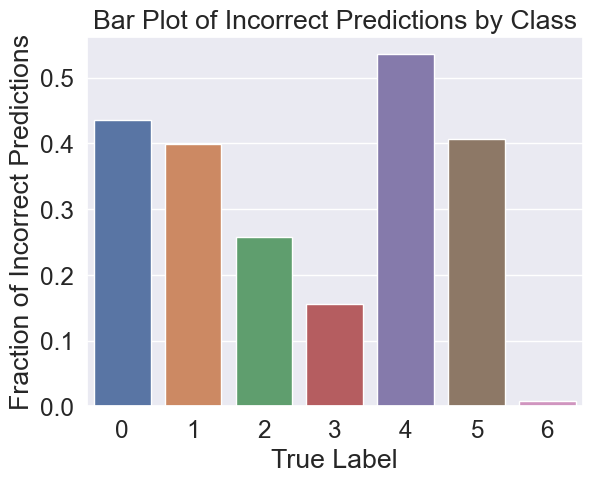

In [82]:
sns.barplot(x=classes, y=incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Bar Plot of Incorrect Predictions by Class')
plt.show()

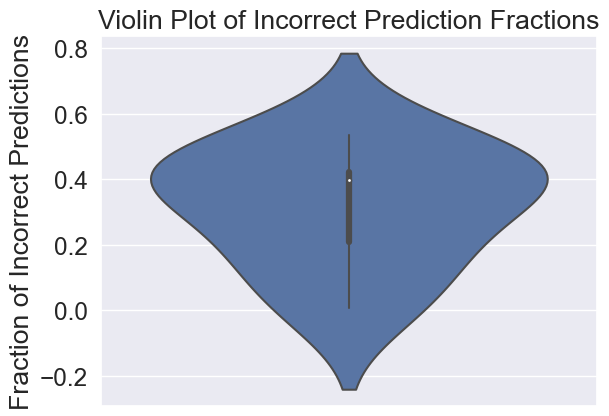

In [83]:
sns.violinplot(y=incorr_fraction)
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Violin Plot of Incorrect Prediction Fractions')
plt.show()

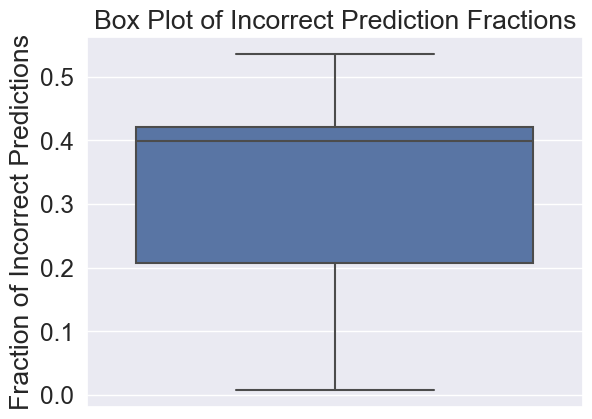

In [84]:
sns.boxplot(y=incorr_fraction)
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Box Plot of Incorrect Prediction Fractions')
plt.show()